## Ejercicio: búsqueda difusa

Dado el siguiente DataFrame, aplicar la búsqueda difusa de strings para la primera palabra de la descripción de cada producto (columna denominación)

Fuentes:
- http://inal.sifega.anmat.gov.ar/consultadeRegistroAlimentos/
- http://datos.salud.gob.ar/dataset/alimentos-libres-de-gluten/archivo/853d467c-5de5-46ae-bf04-5642c4960d1d

In [41]:
!pip install thefuzz[speedup]

In [42]:
from thefuzz import process, fuzz
import pandas as pd

In [43]:
url = "http://datos.salud.gob.ar/dataset/2ebd602e-3138-40c0-847a-f3eb8f520887/resource/853d467c-5de5-46ae-bf04-5642c4960d1d/download/alimentos-libres-de-gluten.csv"
df = pd.read_csv(url)

In [44]:
df.sample()

,marca,nombre_fantasia,denominacion,RNPA
1366,Mogul,Dientes,Pastillas de gomas fantasía sabores a frutilla...,03002834-1


In [45]:
df['denominacion'].value_counts()

Dulce de leche libre de gluten                                                                         74
Queso cremoso libre de gluten                                                                          63
Duraznos amarillos en mitades comunes en jarabe diluido – Libre de gluten                              47
Queso sardo libre de gluten                                                                            45
Queso tybo libre de gluten                                                                             44
                                                                                                       ..
Producto de harina de maíz tipo fideo seco - Libre de gluten - (en sus diversos tamaños y formatos)     1
Pasta fresca rellena sobre congelada: ravioles libre de gluten sin TACC                                 1
Pasta fresca rellena sobrecongelada: sorrentinos libre de gluten sin T.A.C.C.                           1
Pastas frescas con huevo sobrecongelados - Lib

Vemos que hay muchas palabras similares pero escritas distinto

- "libre de gluten" / "Libre de Gluten"  
- "sobre congelada" / "sobrecongeladas"  
- etc

In [46]:
# Contar nulos en "denominacion"
df.denominacion.isnull().sum()

1

In [47]:
# Ver los casos donde "denominacion" es nulo
df[df.denominacion.isnull()]

,marca,nombre_fantasia,denominacion,RNPA
6578,;02-567232,NaN,NaN,NaN


In [48]:
# Descartar casos donde "denominacion" es nulo
df = df.dropna(subset=['denominacion'])

Queremos contar la cantidad de alimentos por categoría ("Queso", "Yogur"...).

Para eso vamos a:
 1. Tomar la primer palabra de "denominacion"
 2. Ver con .value_counts() el resultado

Ahí veremos que hay palabras escritas con variaciones, de número u otras (ej "Lomitos", "Lomito"). Entonces vamos a intentar normalizar las palabras. Para eso tenemos dos enfoques:
A) Normalizar con pasos conocidos:
 1. Pasar a minúsculas
 2. Sacar espacios
 3. Sacar tildes
 4. Sacar puntuación

B) Normalizar palabras infrecuentes.
 1. Tomamos las palabras infrecuentes. Para eso podríamos tomar las que están por debajo de cierto percentil (ej. 1%), o las que aparecen una sola vez
 2. Luego, utilizando búsqueda difusa, intentamos matchear las palabras infrecuentes con las más frecuentes

In [49]:
# Nos quedamos con la primer palabra de "denominacion"
# como palabra clave
df.loc[:, 'simple'] = df['denominacion'].apply(lambda x: x.split()[0])
df['simple'].value_counts()

Queso                       1493
Leche                        682
Alimento                     668
Mermelada                    549
Yogur                        503
                            ... 
Estabilizante                  1
Lomitos                        1
Perejil                        1
Aromatizante/saborizante       1
Vainillas,                     1
Name: simple, Length: 535, dtype: int64

In [50]:
from unidecode import unidecode
import string

def normalizar(s):
    # todo a minusculas
    s = s.lower()
    # sacar espacios
    s = s.strip()
    # sin tildes
    s = unidecode(s)
    # sacamos puntuacion
    letras_no_punct = [l if l not in string.punctuation else '' for l in s]
    return ''.join(letras_no_punct)

# normalizar('Vainillás,')

In [51]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.ratio)[0]
    return mejor_match, puntaje

def find_match(busqueda: str, vocab: list, th=85):
    """Si lo encuentra, devuelve el resultado de la búsqueda. Si no, mantiene lo mismo"""
    match, puntaje = get_match(busqueda, vocab)
    if puntaje > th:
        return match
    else:
        return busqueda

In [52]:
# 535 "categorias" distintas
p = df['simple'].value_counts()
p

Queso                       1493
Leche                        682
Alimento                     668
Mermelada                    549
Yogur                        503
                            ... 
Estabilizante                  1
Lomitos                        1
Perejil                        1
Aromatizante/saborizante       1
Vainillas,                     1
Name: simple, Length: 535, dtype: int64

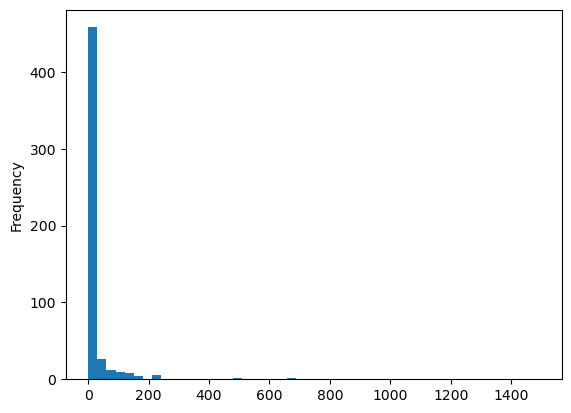

In [53]:
p.plot.hist(bins=50);

In [54]:
p[p == 1].count()

176

In [55]:
dudosas = p[p == 1].index
dudosas

Index(['Trozos', 'Premezcla,', 'Fecula', 'Bastoncitos', 'Biscuits',
       'Polvorones', 'Bebida,', 'Frambuesa', 'Pretzels', 'Guinda',
       ...
       'Acaí', 'Espesantes', 'Cazuela', 'Celulosa', 'Antiaglutinante',
       'Estabilizante', 'Lomitos', 'Perejil', 'Aromatizante/saborizante',
       'Vainillas,'],
      dtype='object', length=176)

In [56]:
vocab = p[p > 1].index
vocab

Index(['Queso', 'Leche', 'Alimento', 'Mermelada', 'Yogur', 'Suplemento',
       'Dulce', 'Galletitas', 'Polvo', 'Bebida',
       ...
       'Moras', 'Durazno', 'Rebozador-', 'Pre-pizza', 'Ñoquis', 'Trigo',
       'Amaranto', 'Cereza', 'Garrapiñada', 'Tallarines'],
      dtype='object', length=359)

In [57]:
matches = dudosas.map(lambda x: find_match(x, vocab))

In [58]:
matches

Index(['Trozos', 'Premezcla', 'Fecula', 'Bastoncitos', 'Biscuits',
       'Polvorones', 'Bebida', 'Frambuesas', 'Pretzel', 'Guindas',
       ...
       'Acaí', 'Espesante', 'Cazuela', 'Celulosa', 'Antiaglutinante',
       'Estabilizante', 'Lomito', 'Perejil', 'Aromatizante/saborizante',
       'Vainillas'],
      dtype='object', length=176)

In [59]:
resultado = pd.DataFrame({'original':dudosas, 'matches':matches})

In [60]:
resultado[resultado['original'] != resultado['matches']]

,original,matches
1,"Premezcla,",Premezcla
6,"Bebida,",Bebida
7,Frambuesa,Frambuesas
8,Pretzels,Pretzel
9,Guinda,Guindas
...,...,...
163,"Mora,",Moras
164,Mora,Moras
167,Espesantes,Espesante
172,Lomitos,Lomito


In [61]:
%%time
df['simple_correct'] = df['simple'].map(lambda x: find_match(x, vocab))

CPU times: user 11.3 s, sys: 0 ns, total: 11.3 s
Wall time: 11.3 s


In [62]:
df['simple_correct'].value_counts()

Queso              1493
Leche               682
Alimento            668
Mermelada           549
Yogur               503
                   ... 
Estabilizante         1
Antiaglutinante       1
Celulosa              1
Acaí                  1
Castañas              1
Name: simple_correct, Length: 457, dtype: int64

# Bonus:
- Aplicar la normalización sobre los nombres completos de los productos.

Va a requerrir un poco más de pasos, ej podrían borrar "sin TACC" (usar RegEx), "libre de gluten"